# 计算智能作业3

## 0. 初始化

**运行环境：**

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

**导入人脸数据集**

In [37]:
#定义数据集所在路径
data_dir = './data/ORL/'
step = 10
n_class = 40

#获取所有的人脸数据文件名
img_names = os.listdir(data_dir)
img_names.sort()
img_names.remove('Thumbs.db')
imgs = [data_dir + img_name for img_name in img_names]
#print(imgs)

#导入人脸数据为ndarry
imgs_array_list = []
for imgname in imgs:
    im = Image.open(imgname)
    imgs_array_list.append(np.array(im))

imgs_dataset = np.asarray(imgs_array_list)

num_sample, img_heigth, img_width = imgs_dataset.shape
print("样本个数: %d\n图片高度: %d\n图片宽度: %d" %(num_sample, img_heigth, img_width))

样本个数: 400
图片高度: 112
图片宽度: 92


**划分数据集**

每个人脸数据的前5张为训练数据，后5张为测试数据。

In [38]:
#数据集切分函数
def split_train_test_data(dataset):
    m, n = dataset.shape[0], dataset.shape[1]*dataset.shape[2]
    #二维矩阵图像数据拉直为一维
    data = dataset.reshape(m, n)
    #生成训练集和测试集的索引
    train_idx = []
    test_idx = []
    for i in range(0, m, step):
        [[train_idx.append(i+j), test_idx.append(i+step//2+j)] for j in range(step//2)]
    
    train_y = test_y = np.ones((m//2,1), dtype=int)
    for i in range(n_class):
        l, r = (step//2)*i, (step//2)*(i+1)
        train_y[l:r,:] = test_y[l:r,:]= i
    return data[train_idx,:], train_y, data[test_idx,:], test_y

train_X, train_y, test_X, test_y = split_train_test_data(imgs_dataset)
print("训练集大小：", train_X.shape, "\n测试集大小：", test_X.shape)

训练集大小： (200, 10304) 
测试集大小： (200, 10304)


**随机显示30张人脸数据**

随机展示30张人脸数据:


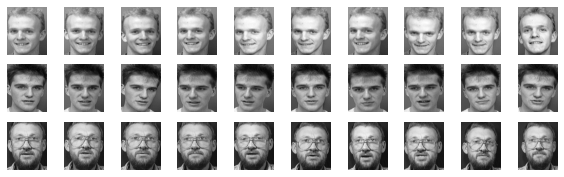

In [39]:
print("随机展示30张人脸数据:")
fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(3):
    m = np.random.randint(0, num_sample)
    m = m - m%10
    for j in range(10):
        axes[i][j].imshow(imgs_dataset[m+j,:], cmap='gray')
        axes[i][j].axis('off')

## 1. LLE降维与人脸数据可视化
将训练样本降到2维，并将部分人脸显示在二维平面上。

In [40]:
#定义参数
n_neighbors = 50
n_dims = 2

In [41]:
#计算任意两点之间的距离矩阵
m, n = train_X.shape
dist_mat = np.zeros([m, m])
for i in range(m):
    dist_mat[i] = np.sum((train_X[i,:].reshape(1, n) - train_X)**2, axis=1)
dist_mat[dist_mat < 0] = 0

#获取n个临界点的位置索引
index_mat = np.argsort(dist_mat, axis=1)[:, 1:n_neighbors+1]
print(index_mat.shape)

(200, 50)


In [42]:
#计算重构权重
w = np.zeros([m, n_neighbors])
for i in range(m):
    X_k = train_X[index_mat[i],:]
    X_i = train_X[i, :].reshape(1, n) #转成1维行向量
    I = np.ones([n_neighbors, 1])

    Si = np.dot((np.dot(I, X_i) - X_k), (np.dot(I, X_i) - X_k).T)

    Si_inv = np.linalg.pinv(Si)
    w[i] = np.dot(I.T, Si_inv)/(np.dot(np.dot(I.T, Si_inv), I))

In [43]:
#计算W
W = np.zeros([m, m])
for i in range(m):
    W[i, index_mat[i]] = w[i]

I_m = np.eye(m)
C = np.dot((I_m - W).T, (I_m - W))

In [44]:
#特征值分解
eignvals, eignvecs = np.linalg.eig(C)

In [45]:
min_eigvals_idx = np.argsort(eignvals)[1:n_dims+1]

train_X_LLE = eignvecs[:, min_eigvals_idx]
print("降维后的数据：", train_X_LLE.shape)

降维后的数据： (200, 2)


**人脸数据在二维平面可视化**

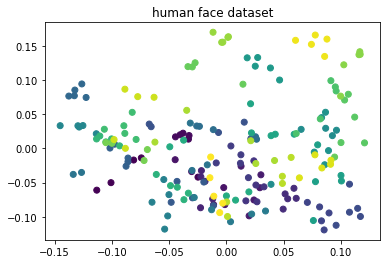

In [46]:
plt.title("human face dataset")
plt.scatter(train_X_LLE[:,0], train_X_LLE[:,1], c=train_y)
plt.show()

## 3. 最小距离分类

比较使用LLE算法将数据集降低到不同维度之后，使用最小距离分类器的分类结果

**定义LLE降维函数**

In [54]:
#定义LLE降维函数
def LLE(data, dim=2, n_neighbors=50):
    #计算任意两点之间的距离矩阵
    m, n = data.shape
    dist_mat = np.zeros([m, m])
    for i in range(m):
        dist_mat[i] = np.sum((data[i, :].reshape(1, n) - data)**2, axis=1)
    dist_mat[dist_mat < 0] = 0

    #获取n个临界点的位置索引
    index_mat = np.argsort(dist_mat, axis=1)[:, 1:n_neighbors+1]
    
    #计算重构权重
    w = np.zeros([m, n_neighbors])
    for i in range(m):
        X_k = data[index_mat[i],:]
        X_i = data[i, :].reshape(1, n) #转成1维行向量
        I = np.ones([n_neighbors, 1])

        Si = np.dot((np.dot(I, X_i) - X_k), (np.dot(I, X_i) - X_k).T)

        Si_inv = np.linalg.pinv(Si)
        w[i] = np.dot(I.T, Si_inv)/(np.dot(np.dot(I.T, Si_inv), I))

    #计算W
    W = np.zeros([m, m])
    for i in range(m):
        W[i, index_mat[i]] = w[i]

    I_m = np.eye(m)
    C = np.dot((I_m - W), (I_m - W).T)

    #特征值分解
    eignvals, eignvecs = np.linalg.eig(C)

    min_eigvals_idx = np.argsort(eignvals)[1:dim+1]

    return eignvecs[:, min_eigvals_idx]

**定义最小分类器分类函数**

In [66]:
#定义最小分类器分类函数
def min_distance_classfier(train, test, labels):
    m, n = train.shape
    mu_list = []
    for i in range(0, m, step//2):
        mu = np.mean(train[i:i+step//2,:], axis=0)
        mu_list.append(mu)
    mu_centers = np.asarray(mu_list)
    
    labels_ = np.zeros([test.shape[0], 1], dtype=int)
    for i in range(test.shape[0]):
        sut = test[i,:]
        dists = np.sum((sut - mu_centers)**2, axis=1)
        
        labels_[i] = np.argsort(dists)[0]
    errorno = np.count_nonzero(labels_ - labels)
    return errorno / test.shape[0], labels_

**观察LLE降维到不同维度之后，使用最小距离分类器分类的错误率**

分别降低到10，20，40，80，160维

In [67]:
dims_list = [10, 20, 40, 80, 160]
errrate_list = []
labels_list = []
for dim in dims_list:
    #print("-- dim=%d" %dim)
    train = LLE(train_X, dim=dim)
    test = LLE(test_X, dim=dim)
    errrate, label = min_distance_classfier(train, test, test_y)
    errrate_list.append(errrate)
    labels_list.append(label)

print(errrate_list)

[0.945, 0.945, 0.94, 0.94, 0.94]


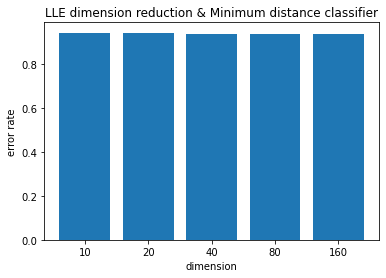

In [68]:
dimsstr_list = [ str(dim) for dim in dims_list]
plt.bar(dimsstr_list, errrate_list)
plt.xlabel('dimension')
plt.ylabel('error rate')
plt.title('LLE dimension reduction & Minimum distance classifier')
plt.show()

结果可见，LLE降维之后使用最小距离分类器的分类效果并不理想。

In [69]:
res_dict = dict(已知类号=list(test_y.flatten()))
for dim, label in zip(dims_list, labels_list):
    res_dict['%d维' %dim] = list(label.flatten())

res_df = pd.DataFrame(res_dict)
pd.set_option('display.max_rows', 500)
res_df

,已知类号,10维,20维,40维,80维,160维
0,0,34,34,0,21,0
1,0,34,25,0,0,11
2,0,39,2,35,17,17
3,0,39,25,35,38,17
4,0,20,34,27,22,27
5,1,24,34,34,35,35
6,1,17,17,32,32,32
7,1,17,17,32,32,32
8,1,34,34,35,21,39
9,1,17,17,32,32,32
